# Malmquist bias
My sample is magnitude limited, and therefore subject to Malmquist bias. For a binary survey, the effect of Malmquist bias is to favor systems with large mass-ratios, since the companion has higher flux. Neglected all other sampling biases such as my vsini limit (which shouldn't introduce a strong bias), the probability of being in my sample is essentially:

\\[
P(obs) =
  \begin{cases}
    1 & \text{if } V < 6 \\
    0 & \text{otherwise}
  \end{cases}
\\]

Now V, the apparent V-band magnitude of the target, is of course a function of the distance ($\rho$) to the star and the absolute magnitude of the star:

$$ V = M_V + 5\log{\rho} - 5 $$

In the case of binary stars, the absolute magnitude is coming from the light of two stars with primary mass $M_1$ and companion mass $qM_1$:

$$ M_{v, total}(q, M_1) = -2.5\log{10^{-M_v(M_1)/2.5} + 10^{-M_v(qM_1)/2.5}} $$

The function $M_v(M)$ is the absolute magnitude of a main-sequence star with mass M, and can be interpolated from stellar evolution models or observational tables such as [this one](http://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.txt). What we want is the probability that a given binary system has $V<6$, as a function of mass-ratio ($q$). Since the conversion from mass to absolute magnitude is not analytical, we will have to do this with a Monte Carlo simulation. We will draw random primary star masses from the Salpeter IMF:

$$P(M)dM \sim M^{-2.35}dM $$
 
Let's normalize it between the primary masses in my sample:

$$ 1 = A\int_{1.5}^{20} m^{-2.35}dm $$
$$ 1 = -\frac{A}{1.35}(20^{-1.35} - 1.5^{-1.35}) $$

In [1]:
# Calculate A
A = -1.35/(20**(-1.35) - 1.5**(-1.35))
print('A = {:.3f}'.format(A))

A = 2.407


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
import numpy as np
%matplotlib inline



The only thing left is to define $M_v(M)$. I will use the empirical table derived by Pecaut & Mamajek, and fit a 'functional' form by using a smoothing spline. I will hand-tweak the smoothing parameter such that the error is less than 0.1 dex.

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


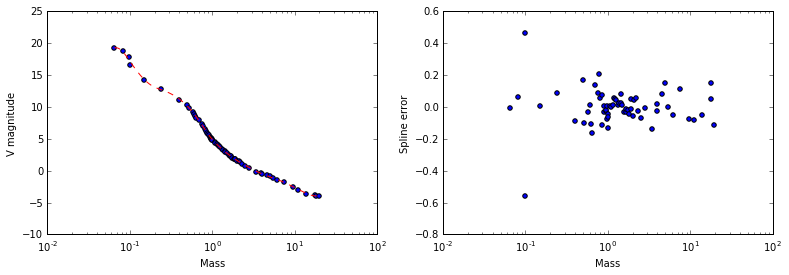

In [3]:
# Take a look at the relation between mass and V-band magnitude for main-sequence stars.
from kglib.spectral_type.Mamajek_Table import MamajekTable
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

# Get the mamajek table. Sort by mass, and remove the NaNs
MT = MamajekTable()
df = MT.mam_df.dropna(subset=['Msun']).sort('Msun')
mass = df['Msun']
vmag = df['Mv']

# Interpolate the table with a smoothing spline.
spline = UnivariateSpline(mass, vmag, s=0.9, ext=3)
mass_plot = np.linspace(min(mass), max(mass), 10000)
predicted = spline(mass_plot)
%matplotlib inline

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 4))
axes[0].set_xscale('log')
axes[1].set_xscale('log')

axes[0].scatter(mass, vmag)
axes[0].plot(mass_plot, predicted, 'r--')
axes[1].scatter(mass, vmag-spline(mass))

axes[0].set_xlabel('Mass')
axes[0].set_ylabel('V magnitude')
axes[1].set_xlabel('Mass')
axes[1].set_ylabel('Spline error')


Finally, we are ready to find put everything together. I will sample 1 million points from the Salpeter IMF between 1.5 and 20 $M_{\odot}$ and 1 million distances drawn from a Milky-Way-like disk. I will then loop over various values of the mass-ratio ($q$) and find the fraction of stars with $V<6$ as a function of mass-ratio.

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


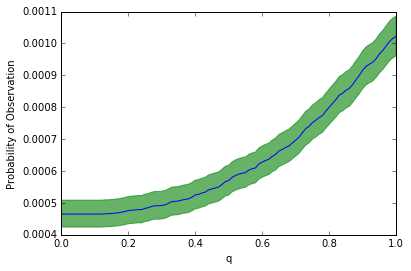

In [8]:
from __future__ import division
import Simulation
from kglib.utils import IMF_utils, HelperFunctions
from kglib.utils.HelperFunctions import add_magnitudes, BinomialErrors
# Sample the distance and primary mass distributions, 
# and find the fraction that fall in my V-band limit as a function of q
N_total = 1e6

def Vmag(q, mass, d):
    """ Get the V-band magnitude as a function of mass-ratio (q), primary mass(mass),
        and distance (d)"""
    M1 = spline(mass)
    M2 = spline(q*mass)
    M_total = add_magnitudes(M1, M2)
    V = M_total + 5*np.log10(d) - 5
    return V


# Sample the distance by simulating a Milky-Way-like disk
z_sun = 25.0
r, z = Simulation.sample_disk(Rmax=1e4, Npoints=N_total, scale_height=150.0)
distance = np.sqrt(r**2 + (z-z_sun)**2)

# Sample the IMF
mass = IMF_utils.inverse_imf(np.random.uniform(size=N_total), mmin=1.5, mmax=20.0)

# Get the V_band magnitude
q = np.arange(0.0, 1.01, 0.01)
prob = np.zeros(q.size)
prob_low = np.zeros(q.size)
prob_high = np.zeros(q.size)
for i, qi in enumerate(q):
    V = Vmag(qi, mass, distance)
    prob[i], prob_low[i], prob_high[i] = BinomialErrors(len(V[V<6]), len(V))
    #prob[i] = len(V[V<6]) / len(V)

# We can't go all the way to zero because the V-magnitude interpolation starts extrapolating
# Instead, assume that P(obs|q<0.1) = P(obs|q)
idx = np.argmin((q - 0.1)**2)
prob[:idx] = prob[idx]
prob_low[:idx] = prob_low[idx]
prob_high[:idx] = prob_high[idx]
    
plt.plot(q, prob)
plt.fill_between(q, prob_low, prob_high, color='green', alpha=0.6)
plt.xlabel('q')
plt.ylabel('Probability of Observation')


           4            3             2
-0.001048 x + 0.002276 x - 0.0009824 x + 0.0002772 x + 0.0003569


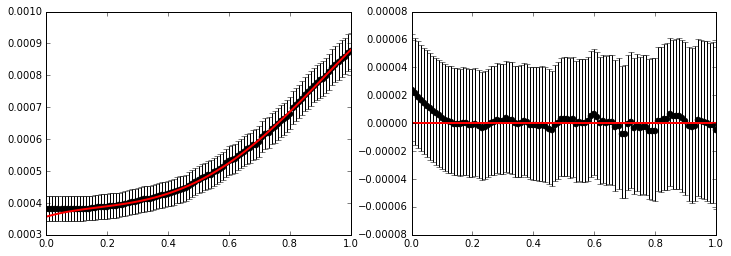

In [5]:
fit = np.poly1d(np.polyfit(q[q>0.1], prob[q>0.1], 4))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].errorbar(q, prob, yerr=(prob-prob_low, prob_high-prob), fmt='ko')
axes[0].plot(q, fit(q), 'r-', lw=2)

#axes[1].scatter(q, (prob - fit(q))/prob*100)
axes[1].errorbar(q, prob-fit(q), yerr=(prob-prob_low, prob_high-prob), fmt='ko')
axes[1].plot(q, np.zeros_like(q), 'r-', lw=2)
#axes[1].set_ylim((-0.001, 0.001))
print fit

In [5]:
fit.coeffs
e, d, c, b, a = fit.coeffs

As expected, the probability of observing a binary system increases with mass-ratio. But that isn't *quite* what I need. What I need is the probability of getting a given mass-ratio, given that I observed it.

$$ P(q|obs) = \frac{P(obs|q)P(q)}{\int P(obs|q)P(q)dq} $$

But $P(q)$ is *precisely* what I am trying to measure in the first place! Let's make sure this looks right by using the power law from De Rosa et al (2014).

0.00904922704892 1.47995822194e-09 0.00811402465052


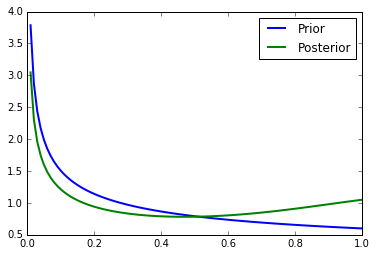

In [12]:
def prior(q, gamma=0.4):
    return (1-gamma)*q**(-gamma)

# Interpolate P(obs|q) (the plot above)
#Pobs = UnivariateSpline(q, prob, s=0, k=1)
Pobs = fit

# Integrate the bottom
from scipy.integrate import quad
denominator, den_err = quad(lambda x: Pobs(x)*prior(x), 0, 1)

# Calculate the true denominator analytically
f, e, d, c, b, a = fit.coeffs
gamma = 0.4
true_denominator = a + (1-gamma)*(b/(2-gamma) + c/(3-gamma) + d/(4-gamma) + e/(5-gamma)) + f/(6-gamma)
print denominator, den_err, true_denominator

# Now, calculate P(q|obs) from Baye's theorem.
Pq = Pobs(q)*prior(q) / denominator

%matplotlib inline
plt.plot(q, prior(q), lw=2, label='Prior')
plt.plot(q, Pq, lw=2, label='Posterior')
plt.legend(loc='best')

That gives the expected result, in that the mass-ratio distribution becomes skewed towards high mass-ratios. 

## How does changing the maximum volume change things?

In the above, there was a variable `Rmax` that defined the maximum distance to search. Does that variable effect the result at all?

          5           4           3           2
-0.01309 x + 0.02555 x - 0.01349 x + 0.01049 x - 0.0009159 x + 0.007291
array([-0.01309283,  0.02554662, -0.01348757,  0.01048769, -0.0009159 ,
        0.00729102])


/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:16: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


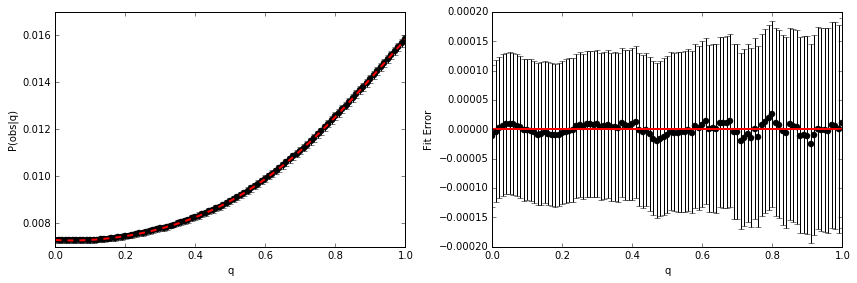

In [9]:
from __future__ import division

# Sample the distance and primary mass distributions, 
# and find the fraction that fall in my V-band limit as a function of q
N_total = 1e7


def get_fit(Rmax, dq=0.03, N_total=1e7, fitorder=5):

    # Sample the distance by simulating a Milky-Way-like disk
    z_sun = 25
    r, z = Simulation.sample_disk(Rmax=1e4, Npoints=N_total, scale_height=150)
    distance = np.sqrt(r**2 + (z-z_sun)**2)

    # Sample the IMF
    mass = IMF_utils.inverse_imf(np.random.uniform(size=N_total), mmin=1.5, mmax=20.0)

    # Get the V_band magnitude
    q = np.arange(0.0, 1.01, dq)
    prob = np.zeros(q.size)
    prob_low = np.zeros(q.size)
    prob_high = np.zeros(q.size)
    for i, qi in enumerate(q):
        V = Vmag(qi, mass, distance)
        prob[i], prob_low[i], prob_high[i] = BinomialErrors(len(V[V<6]), len(V))

    # Compute the sum
    total = prob.sum()
    
    # Fit the probability to a polynomial. 
    fit = np.poly1d(np.polyfit(q, prob/total, fitorder))
    return fit, q, prob/total, (prob-prob_low)/total, (prob_high-prob)/total
    
fit, q, prob, lowerr, higherr = get_fit(Rmax=1e4, dq=0.01, N_total=3e7)

# Make some plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axes[0].errorbar(q, prob, yerr=(lowerr, higherr), fmt='ko')
axes[0].plot(q, fit(q), 'r--', lw=2)
axes[0].set_xlabel('q')
axes[0].set_ylabel('P(obs|q)')

axes[1].errorbar(q, prob-fit(q), yerr=(lowerr, higherr), fmt='ko')
axes[1].plot(q, np.zeros_like(q), 'r-', lw=2)
axes[1].set_xlabel('q')
axes[1].set_ylabel('Fit Error')
#axes[1].set_ylim((-0.001, 0.001))
print fit
print fit.coeffs.__repr__()
plt.tight_layout()

In [14]:
Rmax_values = [100, 1000, 3000, 6000, 9000, 20000]
fit_list = []
fitorder = 5
n_iter = 3
dq = 0.05
coeffs_list = np.empty((len(Rmax_values)*n_iter, fitorder+1))
prob_list = np.empty((len(Rmax_values)*n_iter,int(np.ceil(1.01/dq)) ))
prob_uperr_list = np.empty((len(Rmax_values)*n_iter,int(np.ceil(1.01/dq)) ))
prob_lowerr_list = np.empty((len(Rmax_values)*n_iter,int(np.ceil(1.01/dq)) ))
for i, Rmax in enumerate(Rmax_values):
    #fit_list.append([])
    for n in range(n_iter):
        print(Rmax, n)
        fit, q, prob, lowerr, higherr, _ = get_fit(Rmax, N_total=1e7, fitorder=fitorder, dq=dq)
        coeffs_list[n + i*n_iter] = fit.coeffs
        prob_list[n + i*n_iter] = prob
        prob_uperr_list[n + i*n_iter] = higherr
        prob_lowerr_list[n + i*n_iter] = lowerr

Rmax_list = np.array([np.ones(n_iter)*Rmax for Rmax in Rmax_values]).flatten()
df = pd.DataFrame(data=dict(Rmax=Rmax_list, a=coeffs_list[:, 5], b=coeffs_list[:, 4],
                            c=coeffs_list[:, 3], d=coeffs_list[:, 2], 
                            e=coeffs_list[:, 1], f=coeffs_list[:, 0]))
print(df)

(100, 0)
(100, 1)
(100, 2)
(1000, 0)
(1000, 1)
(1000, 2)
(3000, 0)
(3000, 1)
(3000, 2)
(6000, 0)
(6000, 1)
(6000, 2)
(9000, 0)
(9000, 1)
(9000, 2)
(20000, 0)
(20000, 1)
(20000, 2)
     Rmax         a         b         c         d         e         f
0     100  0.033851 -0.004263  0.053636 -0.077624  0.146276 -0.073615
1     100  0.033784 -0.002927  0.045151 -0.063990  0.147796 -0.082374
2     100  0.034154 -0.005400  0.062371 -0.101189  0.168159 -0.080369
3    1000  0.033820 -0.007282  0.085831 -0.176855  0.265363 -0.122785
4    1000  0.033655 -0.007043  0.076690 -0.140739  0.222017 -0.106380
5    1000  0.033750 -0.005545  0.067689 -0.136789  0.237725 -0.118281
6    3000  0.033961 -0.007397  0.076526 -0.133564  0.201656 -0.093180
7    3000  0.034072 -0.002026  0.041978 -0.064853  0.146767 -0.078051
8    3000  0.034070 -0.005389  0.059699 -0.082698  0.141490 -0.070163
9    6000  0.033750 -0.002984  0.037644 -0.018532  0.068437 -0.040076
10   6000  0.033930 -0.007743  0.081259 -0.151423 

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [22]:
funcs = [np.mean, np.std]
summary = df.groupby('Rmax').agg(dict(a=funcs, b=funcs, c=funcs, d=funcs, e=funcs, f=funcs))

(0, 22000)

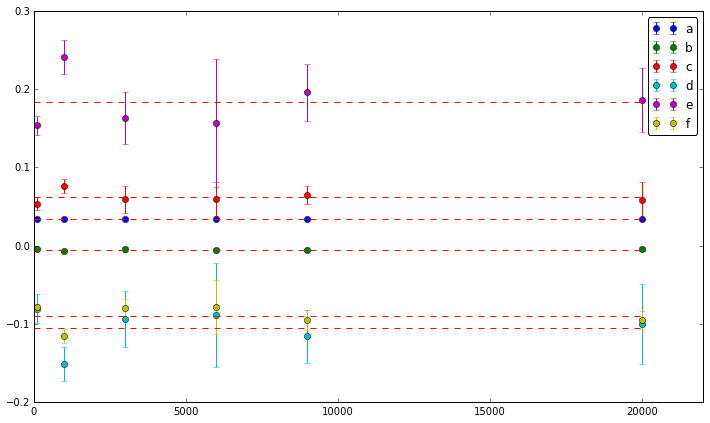

In [25]:
%matplotlib inline
fig = plt.figure(figsize=(12,7))
for coeff_name in ['a', 'b', 'c', 'd', 'e', 'f']:
    subset = summary[coeff_name]
    plt.errorbar(summary.index, subset['mean'], yerr=subset['std'], fmt='o', label=coeff_name)
    plt.plot([0, 20000], [subset['mean'].mean()]*2, 'r--')

plt.legend(loc='best', fancybox=True)
plt.xlim((0, 22000))

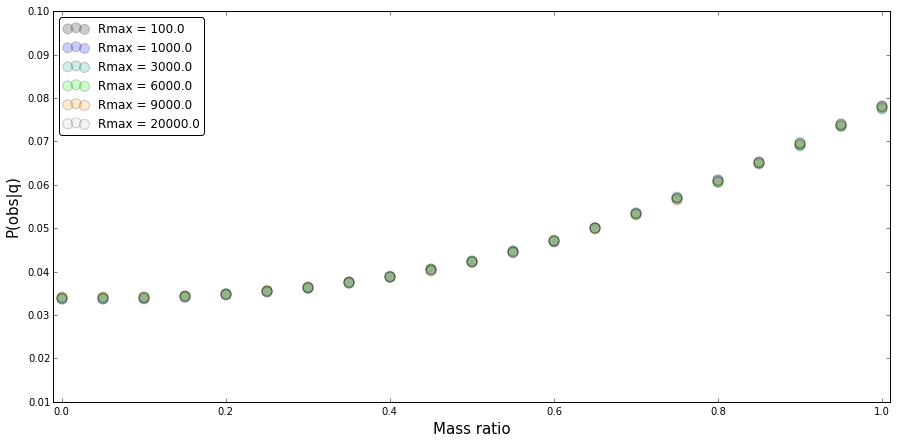

In [20]:
import matplotlib.cm as cm
%matplotlib inline
fig = plt.figure(figsize=(15, 7))
colors = iter(cm.spectral(np.linspace(0, 1, Rmax_list.size/n_iter)))
for i in range(0, Rmax_list.size, n_iter):
    mean_prob = np.mean(prob_list[i:i+n_iter], axis=0)
    plt.scatter(q, mean_prob, c=next(colors), s=100, alpha=0.2, label='Rmax = {}'.format(Rmax_list[i]))
plt.legend(loc=2, fancybox=True)
plt.xlabel('Mass ratio', fontsize=15)
plt.ylabel('P(obs|q)', fontsize=15)
_ = plt.xlim((-0.01, 1.01))

## Punchline: No, `Rmax` doesn't impact the result!